# Project: Build a Traffic Sign Recognition Classifier

In this notebook, an attempt to create better Traffic Sign classifier was made. Originally, it is the task of the second project from Udacity Self-Driving Car Engineer Nanodegree.
This implementation involves Keras with TensorFlow backend.

---
## Step 0: Load The Data

In [1]:
# Load modules
import os
import cv2
import csv
import time
import glob
import h5py
import json
import math
import pickle
import numpy as np
np.random.seed(123) #For reproducability
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
tf.python.control_flow_ops = tf
from keras.models import Sequential
from keras.utils.visualize_util import plot
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda

#Import data
training_file = './train.p'
testing_file = './test.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

Using TensorFlow backend.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

The basic data summary is presented below.

In [2]:
#Number of training examples
n_train = len(y_train)
#Number of testing examples.
n_test = len(y_test)
#Shape of an traffic sign image
image_shape = image_shape = X_train.shape
# Number of unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

img_size=X_train.shape[1] #Size of input images

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (39209, 32, 32, 3)
Number of classes = 43


Visualization of the databas is presente below

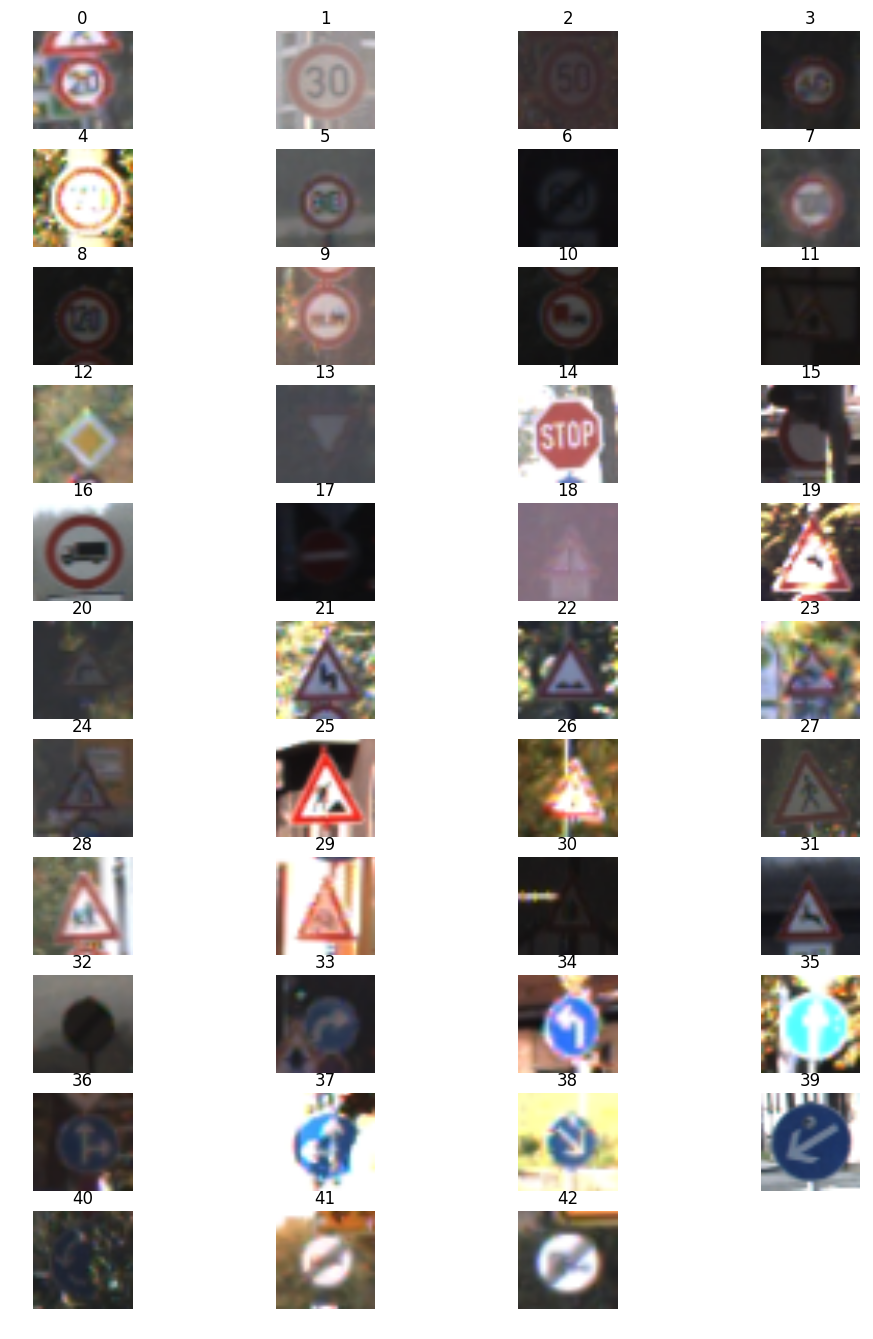

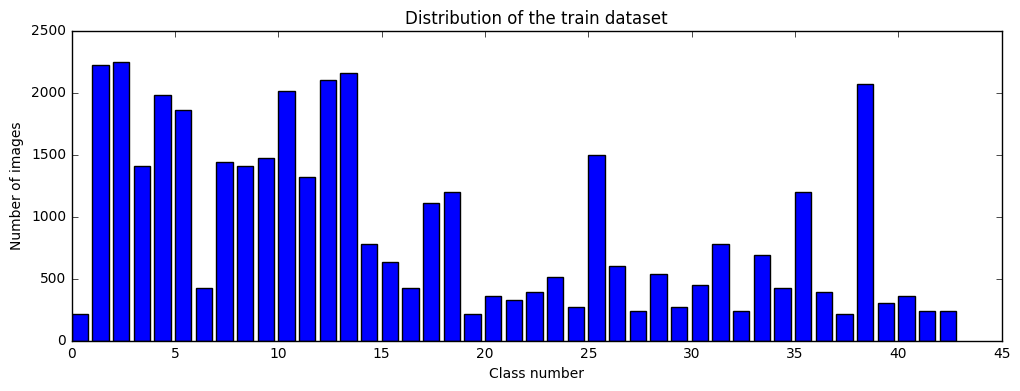

Min number of images per class = 210
Max number of images per class = 2250


In [3]:
### Data exploration visualization goes here.
# Visualizations will be shown in the notebook.
%matplotlib inline

num_of_samples=[]
plt.figure(figsize=(12, 16.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #draw the first image of each class
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

#Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images per class =", min(num_of_samples))
print("Max number of images per class =", max(num_of_samples))

----

## Step 2: Design and Test of the Model Architecture

We will use two CNN^ one for general sign classification and the second - for speed limit signs.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

#Data splitting
np.random.seed(seed=123) #Set seed for reproducability
#Size of the train subset
size_train = 0.8 #80% of the given dataset
size_train = int(size_train*n_train)
#Generate a mask and subsample training and validation da tasets
mask=np.random.permutation(np.arange(n_train))[:size_train]
X_train_sub, y_train_sub=X_train[mask], y_train[mask]
X_val, y_val = np.delete(X_train, mask,0), np.delete(y_train, mask,0)
n_train_sub = len(y_train_sub)
n_val = len(y_val)
print("Number of images in the train dataset = ", n_train_sub)
print("Number of images in the validation dataset = ", n_val)

Number of images in the train dataset =  31367
Number of images in the validation dataset =  7842


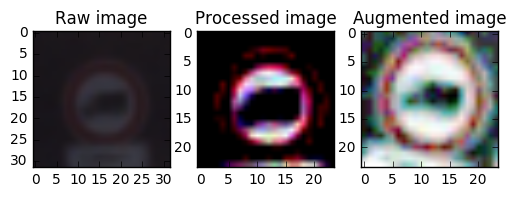

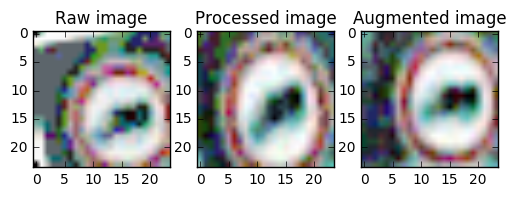

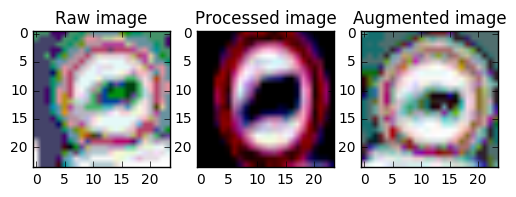

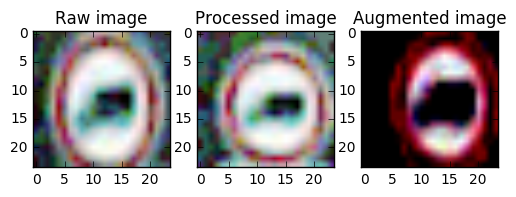

Final image size is (24, 24, 3)


In [155]:
#Some useful image functions
  
def show3img(img, img1, img2):
    plt.figure(figsize=(6, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Raw image")
    plt.subplot(1, 3, 2)
    plt.imshow(img1)
    plt.title("Processed image")
    plt.subplot(1, 3, 3)
    plt.imshow(img2)
    plt.title("Augmented image")
    plt.show()
#Histogram Equalization   
def eq_Hist(img):
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    return img

def scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
    return img2

def crop(img, mar=0):
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

#random subsample image
def crop_rand(img, mar=0):
    shift = (mar-1)*2+1
    a = int(np.random.randint(shift)-shift/2)
    b = int(np.random.randint(shift)-shift/2)
    c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
    return img[(c_x-sh+a):(c_x+sh+a),(c_y-sh+b):(c_y+sh+b)]

def rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

#Compute linear image transformation ing*s+m
def lin_img(img, s=1.0, m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)

def transform_img(img, rand=False):
    img2=sharpen_img(img)
    if rand:
        img2 = crop_rand(img2, 4)
    else:
        img2 = crop(img2, 4)
    img2=contr_img(img2, 1.5)
    return eq_Hist(img2)

def augment_img(img, rand=True):
    img=contr_img(img, 0.9*np.random.rand()+0.1)
    img=rotate_img(img)
    img=scale_img(img)
    return transform_img(img, rand)

x_selected = X_train[y_train == 16]
im=x_selected[90, :, :, :]
imp=contr_img(im, 0.5)

show3img(im, transform_img(im), augment_img(im))
show3img(augment_img(im), augment_img(im), augment_img(im))
show3img(augment_img(im), augment_img(im), augment_img(im))
show3img(augment_img(im), augment_img(im), augment_img(im))
print("Final image size is", transform_img(im).shape)

## Preprocessing

It is obvious that traffic signs on raw images do not cover images from edge to edge. So, cropping was applied (resulted in image resolution reduction from 32x32 px to 26x26 px). It is also beneficial for CNN training speed because we do not need to process some extra useless pixels. Images also demonstrate lack of sharpen, brightness and contrast, that is why sharpen with unsharp mask, contrast enhance and histogram equalization were applied. All operations are called in the __transform_img__ function.

Colors were saved (no grayscale conversion) because color can be the key to traffic sign classification (for example, sign background and edging colors). Some experiments on the same CNN architecture but with grayscale input images were conducted and shown worse results. It is in contrary to the Pierre Sermanet and Yann LeCun results.

In [156]:
### Data augmentation
X_train_aug = []
y_train_aug = []
X_val_prep = []
y_val_prep = []

def y_to_sl(y): #Encode classes so 0 - any speed limit sign
    if y < 9:
        y = 0 #Class 0 - speed limit sign
    else:
        y = y - 8
    return y

def create_data(n=10):
    for i in range(n_train_sub):
        img=X_train_sub[i]
        X_train_aug.append(transform_img(img))
        y = y_train_sub[i]
        y = y_to_sl(y)
        y_train_aug.append(y)
        #Generate n new images out of each input image
        for j in range(n):
            X_train_aug.append(augment_img(img))
            y_train_aug.append(y)       
    for i in range(n_val):
        img = X_val[i]
        X_val_prep.append(transform_img(img))
        y = y_val[i]
        y = y_to_sl(y)
        y_val_prep.append(y)
    print("Total number of images in the augmented dataset = ", len(X_train_aug))

create_data(11)

Total number of images in the augmented dataset =  376404


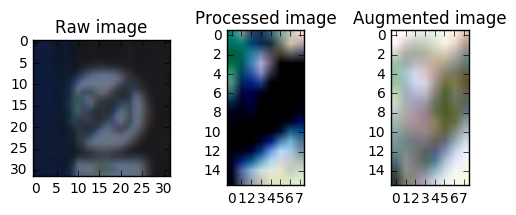

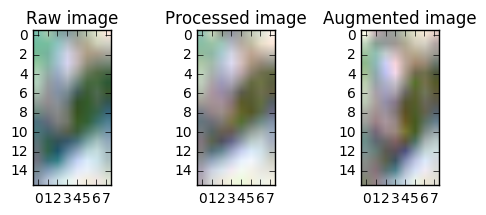

Size of speed limit images is:  (16, 8, 3)
Total number of images in the augmented Speed limit dataset =  115335
Total number of images in the validation Speed limit dataset =  2715


In [148]:
#Create training dataset for speed limit signs
X_train_sl = []
y_train_sl = []
X_val_sl = []
y_val_sl = []
y_min = 6
y_max = 22
x_min = 6
x_max = 14

def augment_img_sl(img):
    img = contr_img(img, 1.2*np.random.rand()+0.2)
    img = rotate_img(img)
    img = scale_img(img)
    img = transform_img(img)
    return img[y_min:y_max, x_min:x_max]


x_selected = X_train[y_train == 6]
im=x_selected[120, :, :, :]
show3img(im, augment_img_sl(im), augment_img_sl(im))
show3img(augment_img_sl(im), augment_img_sl(im), augment_img_sl(im))
print("Size of speed limit images is: ", augment_img_sl(im).shape)


def create_data_sl(n=10):
    for i in range(n_train_sub):
        y = y_train_sub[i]
        if y>8: #If not a speed limit sign
            continue
        img = X_train_sub[i]
        X_train_sl.append(transform_img(img)[y_min:y_max, x_min:x_max])
        y_train_sl.append(y)
        #Generate n new images out of each input image
        for j in range(n):
            X_train_sl.append(augment_img(img, False)[y_min:y_max, x_min:x_max])
            y_train_sl.append(y)       
    for i in range(n_val):
        y = y_val[i]
        if y>8: #If not a speed limit sign
            continue
        img = X_val[i]
        X_val_sl.append(transform_img(img)[y_min:y_max, x_min:x_max])
        y_val_sl.append(y)
    print("Total number of images in the augmented Speed limit dataset = ", len(X_train_sl))
    print("Total number of images in the validation Speed limit dataset = ", len(X_val_sl))
    
create_data_sl(10)

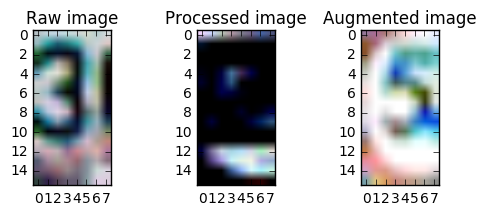

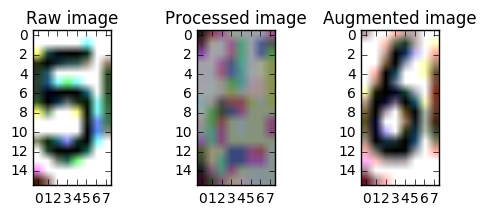

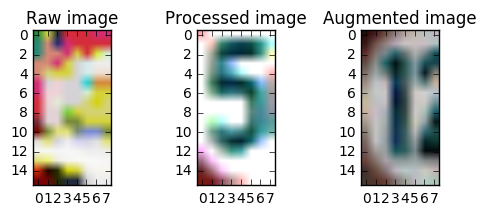

In [149]:
m=len(X_train_sl)
show3img(X_train_sl[np.random.randint(m)], X_train_sl[np.random.randint(m)], X_train_sl[np.random.randint(m)])
show3img(X_train_sl[np.random.randint(m)], X_train_sl[np.random.randint(m)], X_train_sl[np.random.randint(m)])
show3img(X_train_sl[np.random.randint(m)], X_train_sl[np.random.randint(m)], X_train_sl[np.random.randint(m)])

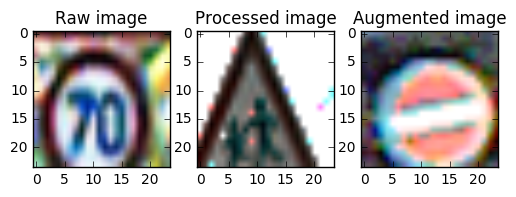

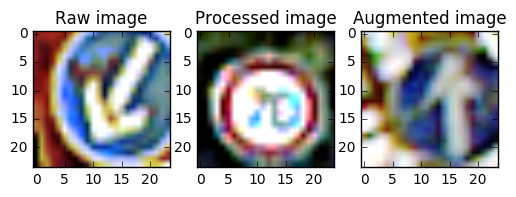

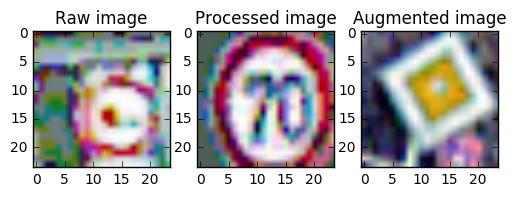

In [162]:
m=len(X_train_aug)
show3img(X_train_aug[np.random.randint(m)], X_train_aug[np.random.randint(m)], X_train_aug[np.random.randint(m)])
show3img(X_train_aug[np.random.randint(m)], X_train_aug[np.random.randint(m)], X_train_aug[np.random.randint(m)])
show3img(X_train_aug[np.random.randint(m)], X_train_aug[np.random.randint(m)], X_train_aug[np.random.randint(m)])


In [163]:
#One Hot encode the labels to the variable y_one_hot

label_binarizer = LabelBinarizer()

y_train_aug_one_hot = label_binarizer.fit_transform(y_train_aug)
y_val_prep_one_hot = label_binarizer.fit_transform(y_val_prep)
y_train_sl_one_hot = label_binarizer.fit_transform(y_train_sl)
y_val_sl_one_hot = label_binarizer.fit_transform(y_val_sl)
y_test_one_hot = label_binarizer.fit_transform(y_test)

print(y_train_aug_one_hot.shape)

(376404, 35)


## Data augmentation

All images were processed by __transform_img__ function as discribed above. Training subset is 80% of initial train.p dataset randomly obtained, validation subset is the rest of the raw train dataset. For testing the full test.p dataset is used.

Training subset was also augmented by generating 10 extra images from every given image. Images were augmented by __augment_img__ function. The process consists of random contrast adjustment, rotation around image center (random value between -15 and 15 deg) and random vertical stretching (as the simplest way to simulate different viewing angle) by random value up to 40 %.

I decided to preserve distribution of signs between classes (see a chart above) as it can be expacted that it minics real-world distribution of signs and in case of unsertanty the CNN more likely will predict mome friquent traffic sign.

In [9]:
#Model saver
def saver(model, model_file, weight_file):
	if Path(model_file).is_file():
		os.remove(model_file)
	if Path(weight_file).is_file():
		os.remove(weight_file)
	with open(model_file,'w' ) as f:
		json.dump(model.to_json(), f)
	model.save_weights(weight_file)
	print("Model saved", model_file, weight_file)

In [164]:
X_train_aug_ar = np.array(X_train_aug)
X_val_prep_ar = np.array(X_val_prep)

In [166]:
#Functional model

from keras.layers import Input
from keras.models import Model
from keras.layers import merge

def inception(x, in_d, out_d, n_int=32):
    conv1x1 = Convolution2D(out_d, 1, 1, border_mode='same', activation='relu')(x)
    conv3x3 = Convolution2D(in_d, 1, 1, border_mode='same')(x)
    conv3x3 = Convolution2D(n_int, 3, 3, border_mode='same', activation='relu')(conv3x3)
    conv3x3 = Convolution2D(out_d, 1, 1, border_mode='same')(conv3x3)
    conv5x5 = Convolution2D(in_d, 1, 1, border_mode='same')(x)
    conv5x5 = Convolution2D(n_int, 5, 5, border_mode='same', activation='relu')(conv5x5)
    conv5x5 = Convolution2D(out_d, 1, 1, border_mode='same')(conv5x5)
    maxpool = MaxPooling2D((2,2), border_mode='same', strides=(1,1))(x)
    maxpool = Convolution2D(out_d, 1, 1, border_mode='same')(maxpool)
    return merge([conv1x1, conv3x3, conv5x5, maxpool],
          mode='concat', concat_axis=3)

inputs = Input(shape=(24, 24, 3))
main_f = Lambda(lambda x: x/255.0-0.5)(inputs)
main_f = Convolution2D(3, 1, 1, border_mode='same')(main_f)
main_f = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(main_f)
main_f = inception(main_f, 32, 32, 32)
main_f = Dropout(0.5)(main_f)
main_f = Convolution2D(64, 3, 3, border_mode='same', subsample=(2,2), activation='relu')(main_f)
main_f = inception(main_f, 32, 64, 32)
main_f = Dropout(0.5)(main_f)
main_f = Convolution2D(128, 3, 3, border_mode='same', subsample=(2,2), activation='relu')(main_f)
main_f = inception(main_f, 32, 64, 32)
main_f = Dropout(0.5)(main_f)
main_f = Convolution2D(256, 3, 3, border_mode='same', subsample=(2,2), activation='relu')(main_f)
main_f = Flatten()(main_f)
main_f = Dense(512, activation='relu')(main_f)
main_f = Dropout(0.5)(main_f)
predictions = Dense(35, activation='softmax')(main_f)

# this creates a model that includes
model_f = Model(input=inputs, output=predictions)
model_f.compile('adam', 'categorical_crossentropy', ['accuracy'])
model_f.load_weights("model_f4.h5")
model_f.summary()
plot(model_f, to_file='model.png', show_shapes=True)
model_f.fit(X_train_aug_ar, y_train_aug_one_hot, batch_size=1024, nb_epoch=5, shuffle=True,
          validation_data=(X_val_prep_ar, y_val_prep_one_hot), verbose=2)

saver(model_f, "model_f5.json", "model_f5.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_24 (InputLayer)            (None, 24, 24, 3)     0                                            
____________________________________________________________________________________________________
lambda_24 (Lambda)               (None, 24, 24, 3)     0           input_24[0][0]                   
____________________________________________________________________________________________________
convolution2d_520 (Convolution2D (None, 24, 24, 3)     12          lambda_24[0][0]                  
____________________________________________________________________________________________________
convolution2d_521 (Convolution2D (None, 24, 24, 64)    4864        convolution2d_520[0][0]          
___________________________________________________________________________________________

In [151]:
#Train the small net for numbers on speed limit signs

X_train_sl_ar = np.array(X_train_sl)
X_val_sl_ar = np.array(X_val_sl)

inputs_s = Input(shape=(16, 8, 3))
main_s = Lambda(lambda x: x/255.0-0.5)(inputs_s)
main_s = Convolution2D(3, 1, 1, border_mode='same')(main_s)
main_s = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(main_s)
main_s = inception(main_s, 32, 64, 32)
main_s = Dropout(0.5)(main_s)
main_s = Convolution2D(128, 3, 3, border_mode='same', subsample=(2,2), activation='relu')(main_s)
main_s = inception(main_s, 64, 128, 64)
main_s = Dropout(0.5)(main_s)
main_s = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(main_s)
main_s = Flatten()(main_s)
main_s = Dense(128, activation='relu')(main_s)
main_s = Dropout(0.5)(main_s)
predictions_s = Dense(9, activation='softmax')(main_s)

# this creates a model that includes
model_s = Model(input=inputs_s, output=predictions_s)
model_s.compile('adam', 'categorical_crossentropy', ['accuracy'])
model_s.load_weights("model_s.h5")
model_s.summary()
plot(model_s, to_file='model_s.png', show_shapes=True)
model_s.fit(X_train_sl_ar, y_train_sl_one_hot, batch_size=1024, nb_epoch=3, shuffle=True,
          validation_data=(X_val_sl_ar, y_val_sl_one_hot), verbose=2)

saver(model_s, "model_s2.json", "model_s2.h5")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_22 (InputLayer)            (None, 16, 8, 3)      0                                            
____________________________________________________________________________________________________
lambda_22 (Lambda)               (None, 16, 8, 3)      0           input_22[0][0]                   
____________________________________________________________________________________________________
convolution2d_472 (Convolution2D (None, 16, 8, 3)      12          lambda_22[0][0]                  
____________________________________________________________________________________________________
convolution2d_473 (Convolution2D (None, 16, 8, 64)     1792        convolution2d_472[0][0]          
___________________________________________________________________________________________

## CNN architecture

The CNN architecture was inspired by [GoogLeNet] (https://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf). Color image with 24x24 px resolution is used as an input, 35 neurons of the output layer represent all traffic sign classes besides speed limit. The CNN consists of three inception modules which are the same to ones from the GoogLeNet, but with two dimension reduction / dimension increase convolution 1x1 layers before and after 3x3 and 5x5 convolutions (for details see `inception` function). The inception modules are alternating with convolutional layers with 2x2 strides and are followed by a fc layer with 512 output neurons. The layers uses 50% dropout and experiments shown that it really help to decrease overfitting.

The architecture was created by a process of trial and error with the idea in mind to minimize computation cost while use inception modules.

## CNN training

Both CNNs was trained with the Adam optimizer, batch size = 1014 images, The model was trained for 15 epochs (376404 images in each epoch) with one dataset.

Traffic sign classes were coded into one-hot encodings.

Training was performed on a GTX 1070 GPU and it takes about one hour. 

In [ ]:
#Prepare testing dataset
X_test_prep=[]
for i in range(n_test):
        img=X_test[i]
        X_test_prep.append(transform_img(img))
X_test_prep_ar = np.array(X_test_prep)

In [170]:
#Run testing
model_f.load_weights("model_f5.h5")
model_s.load_weights("model_s.h5")
pred = model_f.predict(X_test_prep_ar, batch_size=1024, verbose=0)
pred = np.argmax(pred, axis=1)
predictions_f = []
for i, p in enumerate(pred):
    if p == 0: #If speed limit sign, classify it with the second net
        img = X_test[i]
        img = transform_img(img)[y_min:y_max, x_min:x_max]
        img_ar = np.ndarray(shape=(1,16,8,3), dtype=float)
        img_ar[0] = np.array(img)
        predictions_f.append(np.argmax(model_s.predict(img_ar, batch_size=1)))
    else:
        predictions_f.append(p+8)
predictions_f = np.array(predictions_f)

In [173]:
correct = 0
for i in range(len(y_test)):
    if y_test[i]==predictions_f[i]:
        correct += 1
        
print("Accuracy: ", correct*100./len(y_test))


Accuracy:  94.12509897070467


In [177]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions_f)
cnf_matrix_norm = cnf_matrix / cnf_matrix.sum(axis=1)

print(cnf_matrix_norm[:,19])
cnf_matrix_norm_d = cnf_matrix_norm.diagonal()
for i in range(42):
    print(i, cnf_matrix_norm_d[i])

print(np.mean(cnf_matrix_norm_d))

[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
0 1.0
1 0.984722222222
2 0.988
3 0.96
4 0.942424242424
5 0.955555555556
6 0.78
7 0.86
8 0.897777777778
9 0.872916666667
10 0.940909090909
11 0.95
12 0.960869565217
13 0.998611111111
14 1.0
15 0.980952380952
16 1.0
17 1.0
18 0.812820512821
19 0.5
20 1.0
21 0.988888888889
22 0.966666666667
23 0.8
24 0.955555555556
25 0.98125
26 0.988888888889
27 0.783333333333
28 0.986666666667
29 0.977777777778
30 0.746666666667
31 0.888888888889
32 1.0
33 1.0
34 1.0
35 0.910256410256
36 0.966666666667
37 0.916666666667
38 0.995652173913
39 0.666666666667
40 0.933333333333
41 0.716666666667
0.91861617413


---

## Step 3: Test a Model on New Images

`signnames.csv` contains mappings from the class id (integer) to the actual sign name.

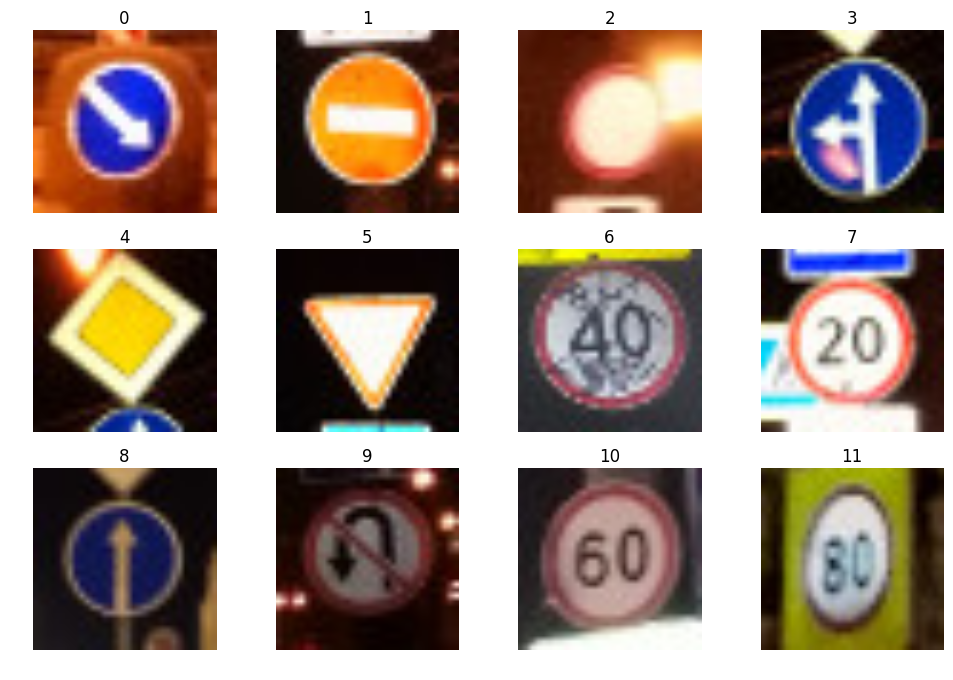

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#Import traffic signs class names
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))

#Import test images  
test_img_paths = [img_path for img_path in glob.glob("./new_images/*")]
test_img=np.uint8(np.zeros((12,32,32,3)))
for i, imp in enumerate(test_img_paths):
    img=cv2.imread(imp, cv2.IMREAD_COLOR)
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    test_img[i]=img

#Visualize new raw images
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_img[i]) 
    plt.title(i)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
plt.show()

**Answer:**

There are 10 real traffic signs from Moscow streets correspond to presented in the train dataset classes. They have a little bit different to the test dataset colors and arrows style. The also was taken at night with a flashlight, so, background and signs brightness can be challenging. Some traffic signs are dirty or images are light damaged.

There are 2 additional road signs missing in the training dataset ( "No U-turn" and "speed limit (40 km / h)"). They should not be used to assess the accuracy, but included as experiment.

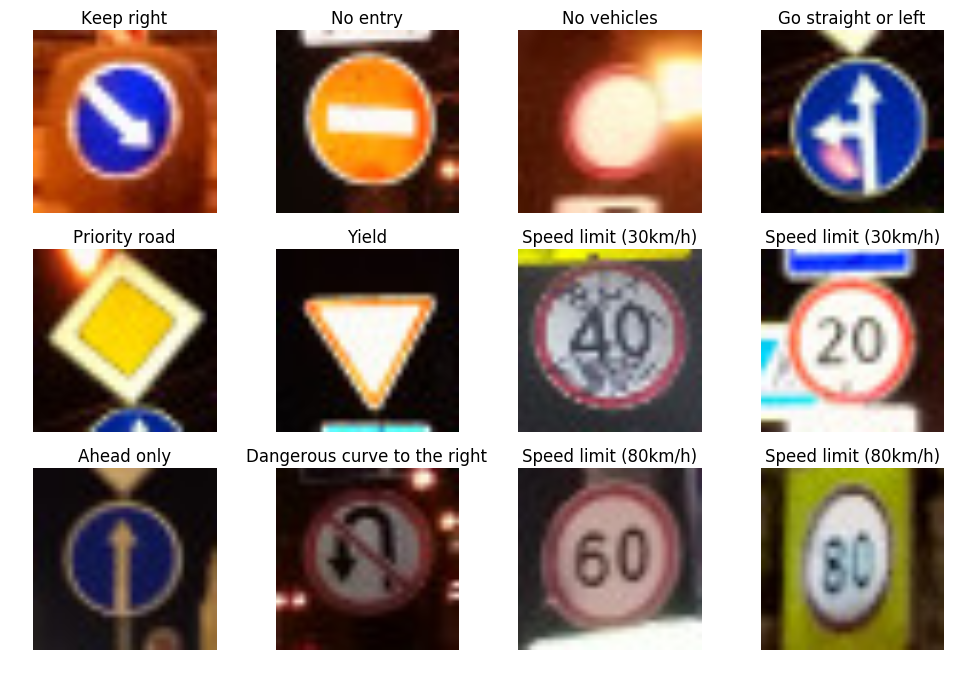

In [30]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
def test_net(X_data, sess):
    pred_sign = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.0})
    return pred_sign

X_test_data=np.uint8(np.zeros((12,26,26,3)))
for i in range(12):
    img=test_img[i]
    X_test_data[i]=transform_img(img)

X_test_data = X_test_data.reshape((-1, 26, 26, 3)).astype(np.float32)
    
with tf.Session() as sess:
    saver.restore(sess, './my_net_f.ckpt')
    signs_classes=test_net(X_test_data, sess)


plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(test_img[i]) 
    plt.title(signs_class[signs_classes[i]])
    plt.axis('off')
plt.show()

**Answer:**

We can see that 2 of traffic signs of presented in the training set classes were misclassified ("speed limit (20 km / h)" and "speed limit (60 km / h)"). In both cases net correctly respond that they were a speed limit signs, so only numbers were recognized incorrectly. (One of the possible solution for real world application is to train another NN to classify numbers only). So, accuracy is about 80% on the real world extra images.

Extra sign "speed limit (40 km / h)" was misclassified (obviously) as a another speed limit sign, so, the CNN can understand traffic sign types quite well. 

In [47]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def test_net(X_data, sess): 
    prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_data, keep_prob: 1.0})    
    top_5 = tf.nn.top_k(prob, k=5)
    return sess.run(top_5)


with tf.Session() as sess:
    saver.restore(sess, './my_net_f.ckpt')
    signs_top_5=test_net(X_test_data, sess)

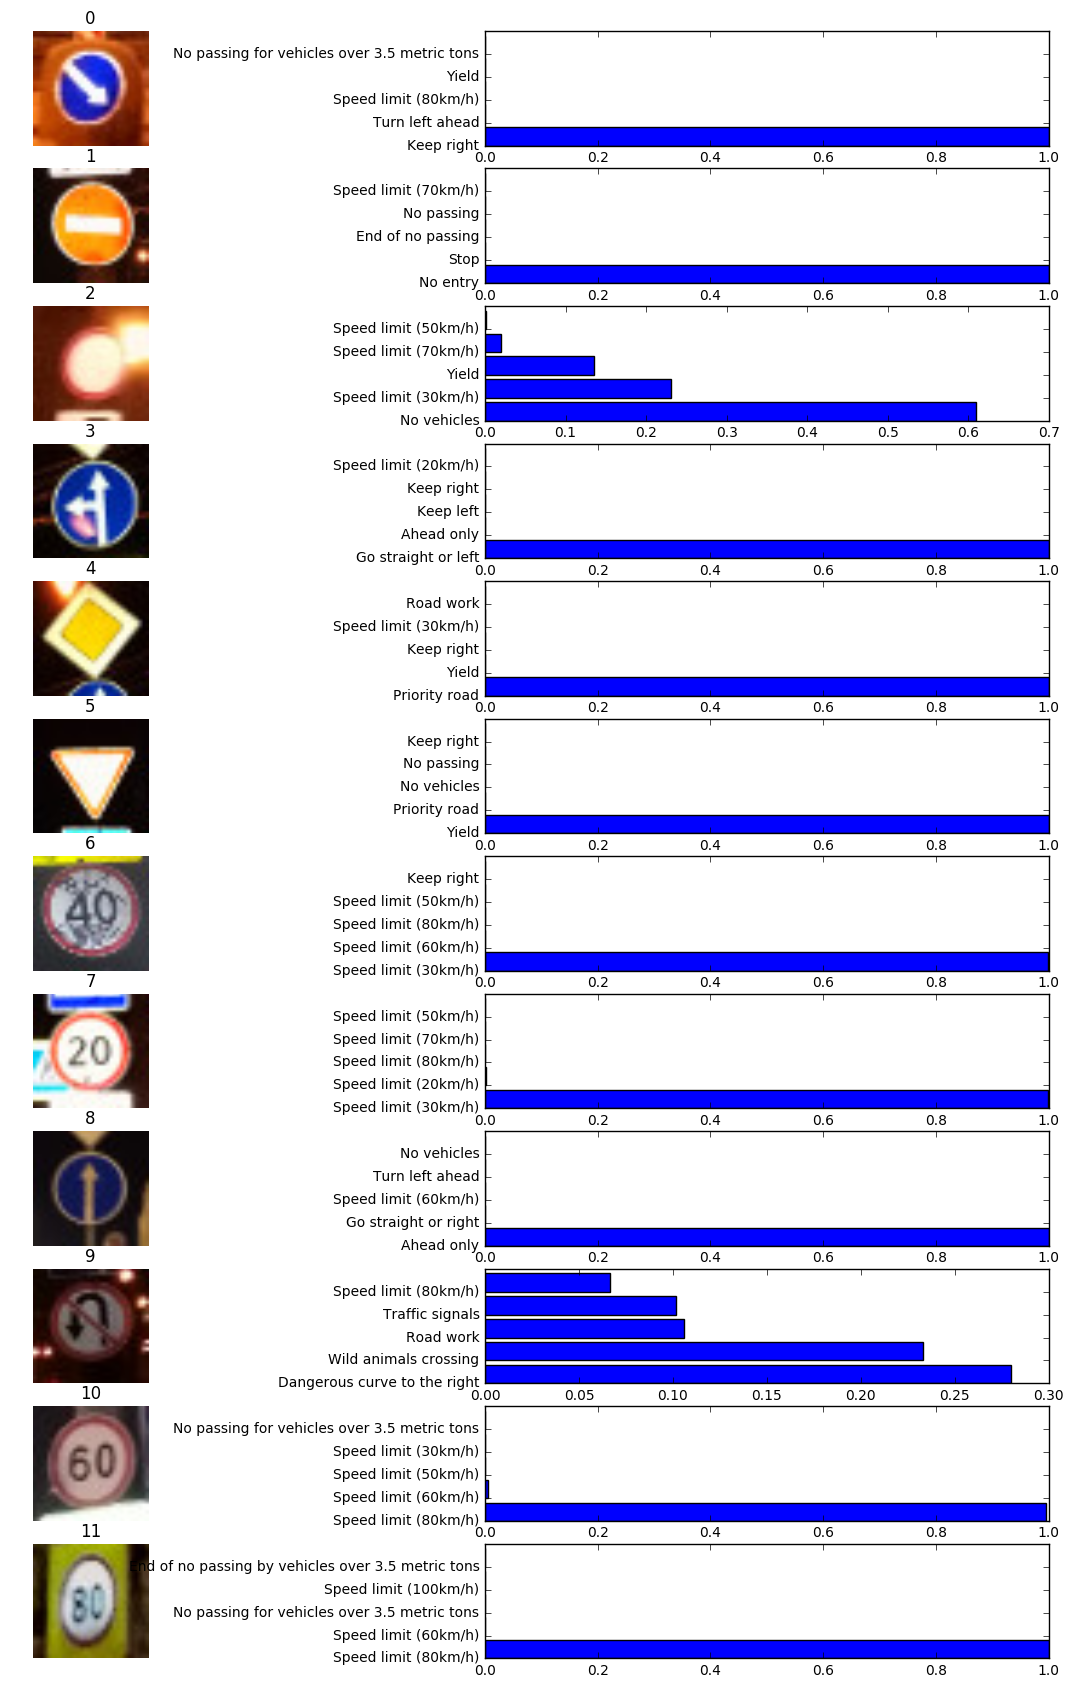

In [49]:
plt.figure(figsize=(16, 21))
for i in range(12):
    plt.subplot(12, 2, 2*i+1)
    plt.imshow(test_img[i]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(12, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), signs_top_5.values[i, :])
    labs=[signs_class[j] for j in signs_top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()

**Answer:**

In all cases except the extra sign "No U-turn" the predictor was very certain. In case of misclassified speed limit signs the correct predictions were the second probable option. "No vehicles" presented some difficulties as it has a big hotspot, but was classified correctly. So, the system is quite reliable and with some modifications it could perform really well on real data.